In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
!unzip  drive/MyDrive/data/GAN/all.zip -d ./all/  > /dev/null

In [ ]:
!unzip  drive/MyDrive/data/GAN/06.04.zip -d ./6.4/  > /dev/null

In [ ]:
!unzip drive/MyDrive/data/GAN/11.03.zip -d ./11.3/ > /dev/null

In [ ]:
!unzip drive/MyDrive/data/GAN/23.03.zip -d ./23.3/ > /dev/null

In [ ]:
codings_size = 100
batch_size = 32
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
image_train_gen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255.,
                                                         horizontal_flip=True,
                                                         fill_mode="nearest",
                                                         validation_split=0.2
                                                         )

image_test_gen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255.,
                                                         horizontal_flip=True,
                                                         fill_mode="nearest"
                                                         )

## not necessarry here because we need just one class (normal)
train_images = image_train_gen.flow_from_directory(
    directory="./all/",
    color_mode="rgb",
    class_mode="input",
    subset='training',
    classes=['OK'],
    seed=42
    )
valid_images = image_train_gen.flow_from_directory(
    directory="./all/",
    color_mode="rgb",
    class_mode="input",
    subset='validation',
    classes=['OK'],
    seed=42
    )
test_images = image_test_gen.flow_from_directory(
    directory="./all/",
    color_mode="rgb",
    class_mode="input",
    classes=['DEF'],
    seed=42
    )

Found 1816 images belonging to 1 classes.
Found 454 images belonging to 1 classes.
Found 2114 images belonging to 1 classes.


In [ ]:
encoder = keras.models.Sequential([
   keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu", input_shape=[256, 256, 3]),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.Dropout(0.5),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2)
   ])

decoder = keras.models.Sequential([
  keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="selu", input_shape=[8, 8, 256]),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="selu"),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu"),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
  keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid")
])

autoencoder = keras.models.Sequential([encoder, decoder])


In [ ]:
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                        

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/MyDrive/models/AE/all/autoencoder-{epoch:02d}-{val_accuracy:.2f}.hdf5",  monitor='val_accuracy', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

autoencoder.fit(train_images, epochs=500, shuffle=True, validation_data=(valid_images), callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/500
57/57 [==============================] - 36s 614ms/step - loss: 0.0473 - accuracy: 0.7869 - val_loss: 0.0215 - val_accuracy: 0.9514
Epoch 2/500
57/57 [==============================] - 34s 592ms/step - loss: 0.0135 - accuracy: 0.8973 - val_loss: 0.0434 - val_accuracy: 0.9531
Epoch 3/500
57/57 [==============================] - 33s 585ms/step - loss: 0.0103 - accuracy: 0.9082 - val_loss: 0.0553 - val_accuracy: 0.9484
Epoch 4/500
57/57 [==============================] - 33s 578ms/step - loss: 0.0076 - accuracy: 0.9200 - val_loss: 0.0744 - val_accuracy: 0.9340
Epoch 5/500
57/57 [==============================] - 33s 574ms/step - loss: 0.0071 - accuracy: 0.9213 - val_loss: 0.1324 - val_accuracy: 0.8272
Epoch 6/500
57/57 [==============================] - 33s 576ms/step - loss: 0.0063 - accuracy: 0.9274 - val_loss: 0.0366 - val_accuracy: 0.9498
Epoch 7/500
57/57 [==============================] - 33s 578ms/step - loss: 0.0056 - accuracy: 0.9332 - val_loss: 0.0260 - val_accuracy:

In [ ]:
model = keras.models.load_model("drive/MyDrive/models/AE/all/autoencoder-68-0.97.hdf5")

In [ ]:
metrics = []
path = glob.glob("./6.4/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 354/354 [00:20<00:00, 17.18it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
TN = len(metrics[metrics[:, 0] < 0.0033])
print(TN)
print (TN / len(metrics) * 100 )

241
68.07909604519774


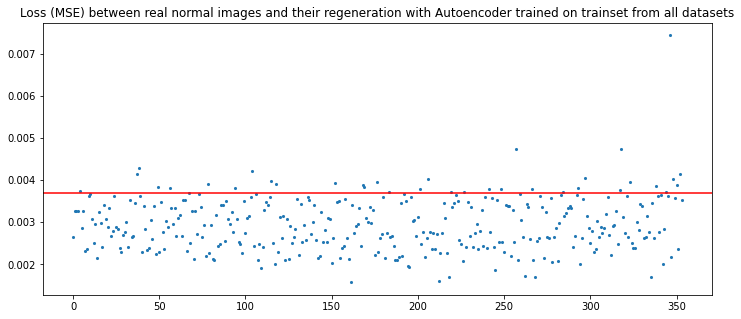

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real normal images and their regeneration with Autoencoder trained on trainset from all datasets")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics_ = []
path = glob.glob("./6.4/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics_.append(model.evaluate(img, img, verbose=0))

100%|██████████| 285/285 [00:14<00:00, 19.27it/s]


In [ ]:
metrics_ = np.asarray(metrics_)
np.shape(metrics_)
TP = len(metrics_[metrics_[:, 0] > 0.0033])
print(TP)
print (TP / len(metrics_) * 100 )

217
76.14035087719299


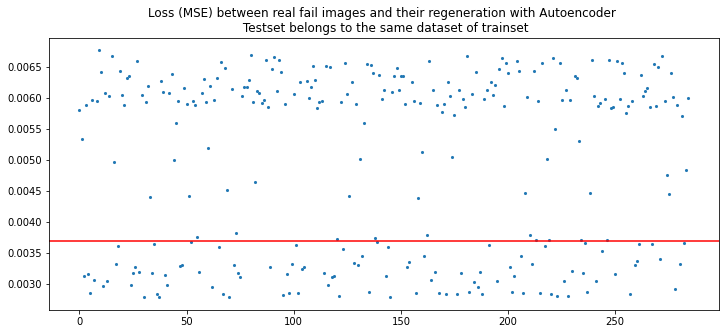

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics_))
y = metrics_[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset belongs to the same dataset of trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./11.3/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 659/659 [00:35<00:00, 18.73it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
TN = len(metrics[metrics[:, 0] < 0.0033])
print(TN)
print (TN / len(metrics) * 100 )

574
87.10166919575114


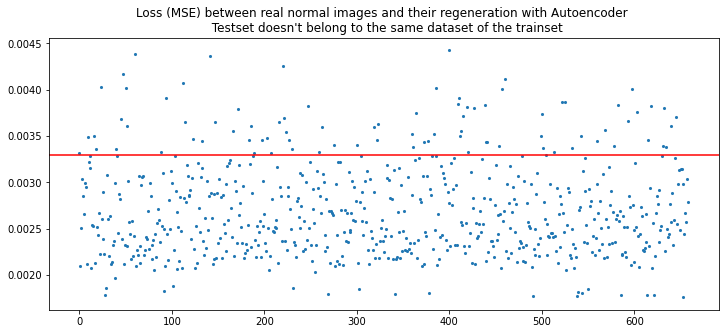

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real normal images and their regeneration with Autoencoder \n  Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0033, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./11.3/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 557/557 [00:30<00:00, 18.48it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
TP = len(metrics[metrics[:, 0] > 0.0033])
print(TP)
print (TP / len(metrics) * 100 )

27
4.847396768402154


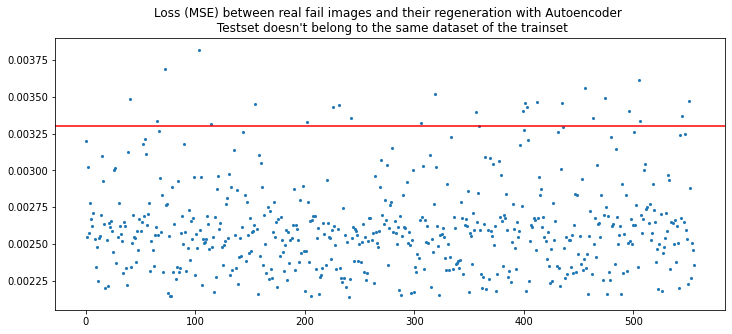

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0033, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./23.3/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 1260/1260 [01:06<00:00, 18.97it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] < 0.0033])
print(TN)
print (TN / len(metrics) * 100 )

[0.00251239 0.94615173]
1249
99.12698412698413


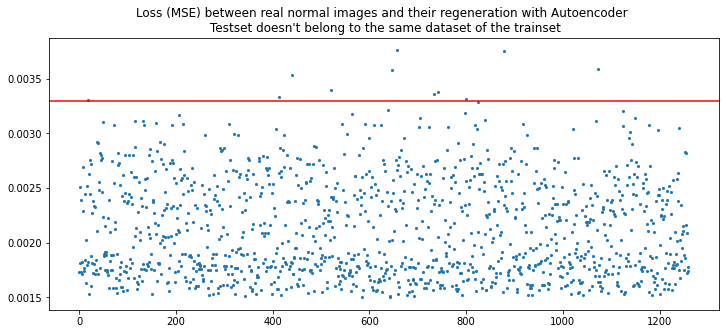

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real normal images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0033, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./23.3/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 1213/1213 [01:04<00:00, 18.95it/s]


1/1 [==============================] - 0s 22ms/step - loss: 0.0028 - accuracy: 0.9653


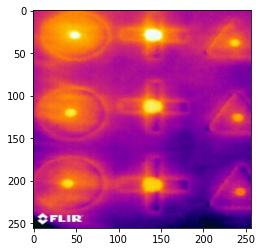

In [ ]:
img = plt.imread("./11.3/DEF/Video_2022-03-11T143455474.avi103730.jpg")
img = cv2.resize(img,(256,256))
img  = img / 255.
plt.imshow(img)
img = np.asarray([img])
metrics = model.evaluate(img, img, verbose=1)

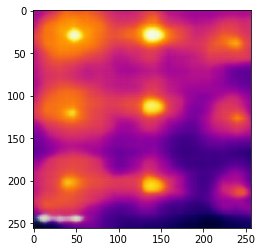

In [ ]:
img_pred = model.predict(img)
plt.imshow(img_pred[0])

In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TP = len(metrics[metrics[:, 0] > 0.0033])
print(TP)
print (TP / len(metrics) * 100 )

[0.0021261  0.97491455]
55
4.534212695795548


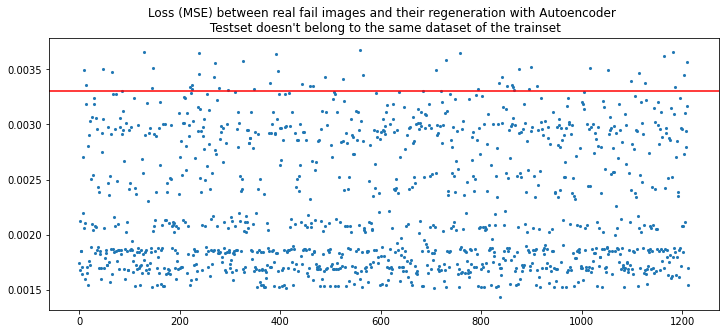

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0033, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./all/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 2270/2270 [01:58<00:00, 19.15it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] < 0.0025])
print(TN)
print (TN / len(metrics) * 100 )

[0.00277746 0.9503479 ]
1241
54.669603524229075


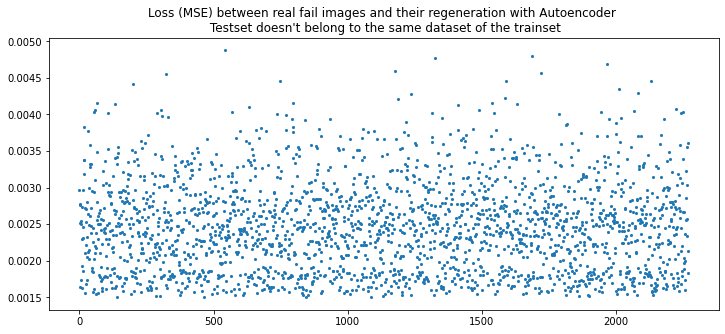

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
# ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics_ = []
path = glob.glob("./all/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics_.append(model.evaluate(img, img, verbose=0))

100%|██████████| 2114/2114 [01:51<00:00, 18.99it/s]


In [ ]:
metrics_ = np.asarray(metrics_)
np.shape(metrics_)
print(metrics_[1])
TN = len(metrics_[metrics_[:, 0] > 0.0025])
print(TN)
print (TN / len(metrics_) * 100 )

[0.00319843 0.9467926 ]
1139
53.87890255439925


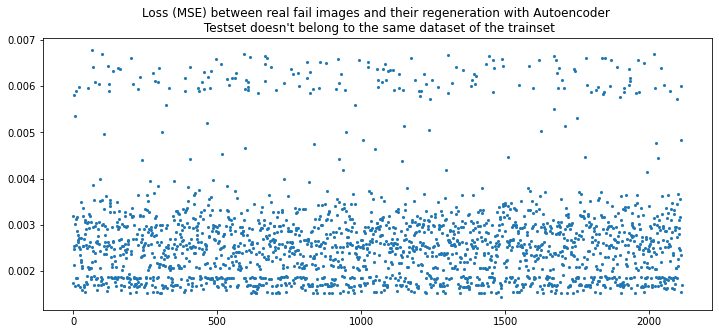

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics_))
y = metrics_[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
# ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()